In [33]:
import pandas as pd 
import geopandas as gpd 


In [34]:
input_path = "../data/input/"
output_path = "../data/output/"

### import Main data: 

In [35]:
main_data = pd.read_parquet(input_path + "yellow_tripdata_2024_01.parquet")

In [36]:
main_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [37]:
main_data['PULocationID'].nunique() 

260

In [38]:
main_data['DOLocationID'].nunique()

261

### import the zones detailed data + create the latitude and longitude columns: 

In [39]:

# Read the shapefile
gdf = gpd.read_file(input_path + "zones/taxi_zones.shp")

In [40]:
gdf.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


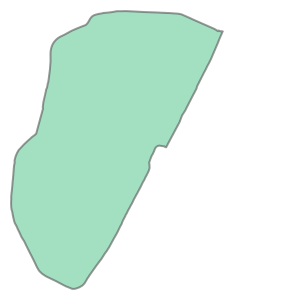

In [41]:
gdf['geometry'][0]

In [42]:
print(gdf.geometry.centroid)


0        POINT (935996.821 191376.75)
1      POINT (1031085.719 164018.754)
2      POINT (1026452.617 254265.479)
3       POINT (990633.981 202959.782)
4        POINT (931871.37 140681.351)
                    ...              
258    POINT (1025106.231 266453.415)
259    POINT (1010211.977 210434.892)
260     POINT (980639.512 197635.174)
261     POINT (999064.725 221974.401)
262      POINT (997817.92 223005.988)
Length: 263, dtype: geometry


In [43]:
# Extract latitude and longitude separately
gdf['latitude'] = gdf.geometry.centroid.y
gdf['longitude'] = gdf.geometry.centroid.x



In [44]:
print(gdf[['zone', 'latitude', 'longitude']])

                        zone       latitude     longitude
0             Newark Airport  191376.749531  9.359968e+05
1                Jamaica Bay  164018.754403  1.031086e+06
2    Allerton/Pelham Gardens  254265.478659  1.026453e+06
3              Alphabet City  202959.782391  9.906340e+05
4              Arden Heights  140681.351376  9.318714e+05
..                       ...            ...           ...
258       Woodlawn/Wakefield  266453.414552  1.025106e+06
259                 Woodside  210434.891894  1.010212e+06
260       World Trade Center  197635.173702  9.806395e+05
261           Yorkville East  221974.400788  9.990647e+05
262           Yorkville West  223005.988409  9.978179e+05

[263 rows x 3 columns]


In [45]:
gdf_join = gdf[['LocationID', 'zone', 'borough', 'latitude', 'longitude']]

### join the zone data wiht the main data: 

In [46]:
# Join with pickup location
main_data = main_data.merge(gdf_join.rename(columns={'LocationID': 'PULocationID', 
                                                       'zone': 'pickup_zone', 
                                                       'borough': 'pickup_borough', 
                                                       'latitude': 'pickup_latitude', 
                                                       'longitude': 'pickup_longitude'}), 
                            on='PULocationID', how='left')

# Join with dropoff location
main_data = main_data.merge(gdf_join.rename(columns={'LocationID': 'DOLocationID', 
                                                       'zone': 'dropoff_zone', 
                                                       'borough': 'dropoff_borough', 
                                                       'latitude': 'dropoff_latitude', 
                                                       'longitude': 'dropoff_longitude'}), 
                            on='DOLocationID', how='left')

In [47]:
main_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,congestion_surcharge,Airport_fee,pickup_zone,pickup_borough,pickup_latitude,pickup_longitude,dropoff_zone,dropoff_borough,dropoff_latitude,dropoff_longitude
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,...,2.5,0.0,Penn Station/Madison Sq West,Manhattan,211974.446219,986345.398600,East Village,Manhattan,204368.501875,988147.657991
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,...,2.5,0.0,Lenox Hill East,Manhattan,218166.434353,996787.663055,Upper East Side North,Manhattan,223613.753576,996155.386766
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,...,2.5,0.0,Upper East Side North,Manhattan,223613.753576,996155.386766,East Village,Manhattan,204368.501875,988147.657991
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,...,2.5,0.0,East Village,Manhattan,204368.501875,988147.657991,SoHo,Manhattan,203008.491333,983823.807116
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,...,2.5,0.0,SoHo,Manhattan,203008.491333,983823.807116,Lower East Side,Manhattan,201205.264892,986773.546092


In [48]:
main_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'pickup_zone',
       'pickup_borough', 'pickup_latitude', 'pickup_longitude', 'dropoff_zone',
       'dropoff_borough', 'dropoff_latitude', 'dropoff_longitude'],
      dtype='object')

In [49]:
best_columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID',
       'payment_type', 'fare_amount', 'total_amount', 
       'pickup_zone', 'pickup_borough', 'pickup_latitude', 'pickup_longitude', 
       'dropoff_zone', 'dropoff_borough', 'dropoff_latitude', 'dropoff_longitude']

In [50]:
''' 
this is what the professor needs:
trip_id, pickup_datetime, pickup_location (longitude, latitude, borough),
dropoff_location, passenger_count, trip_distance, fare_amount.
'''

prof_needs = ['tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'fare_amount',
       'pickup_borough', 'pickup_latitude', 'pickup_longitude', 
       'dropoff_borough', 'dropoff_latitude', 'dropoff_longitude']

In [51]:
final_main_data = main_data[best_columns]

In [52]:
final_main_data_prof_col = main_data[prof_needs]

### save the data as json file

In [ ]:
# Add id column
final_main_data.insert(0, 'id', range(1, len(final_main_data) + 1))

# Save as JSON
final_main_data.to_json(output_path + 'final_data.json', orient='records', indent=2 , date_format='iso')

print(f"File saved to {output_path}final_data.json")
print(f"Total records: {len(final_main_data)}")
print(final_main_data.head())


File saved to ../data/output/final_data.json
Total records: 2965795
   id tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0   1  2024-01-01 00:57:55   2024-01-01 01:17:43              1.0   
1   2  2024-01-01 00:03:00   2024-01-01 00:09:36              1.0   
2   3  2024-01-01 00:17:06   2024-01-01 00:35:01              1.0   
3   4  2024-01-01 00:36:38   2024-01-01 00:44:56              1.0   
4   5  2024-01-01 00:46:51   2024-01-01 00:52:57              1.0   

   trip_distance  RatecodeID  payment_type  fare_amount  total_amount  \
0           1.72         1.0             2         17.7         22.70   
1           1.80         1.0             1         10.0         18.75   
2           4.70         1.0             1         23.3         31.30   
3           1.40         1.0             1         10.0         17.00   
4           0.80         1.0             1          7.9         16.10   

                    pickup_zone pickup_borough  pickup_latitude  \
0  Penn Sta

In [ ]:
# Add id column
final_main_data_prof_col.insert(0, 'id', range(1, len(final_main_data_prof_col) + 1))

# Save as JSON
final_main_data_prof_col.to_json(output_path + 'final_data_prof_col.json', orient='records', indent=2 , date_format='iso')

print(f"File saved to {output_path}final_data_prof_col.json")
print(f"Total records: {len(final_main_data_prof_col)}")
print(final_main_data_prof_col.head())

File saved to ../data/output/final_data_prof_col.json
Total records: 2965795
   id tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0   1  2024-01-01 00:57:55   2024-01-01 01:17:43              1.0   
1   2  2024-01-01 00:03:00   2024-01-01 00:09:36              1.0   
2   3  2024-01-01 00:17:06   2024-01-01 00:35:01              1.0   
3   4  2024-01-01 00:36:38   2024-01-01 00:44:56              1.0   
4   5  2024-01-01 00:46:51   2024-01-01 00:52:57              1.0   

   trip_distance  fare_amount pickup_borough  pickup_latitude  \
0           1.72         17.7      Manhattan    211974.446219   
1           1.80         10.0      Manhattan    218166.434353   
2           4.70         23.3      Manhattan    223613.753576   
3           1.40         10.0      Manhattan    204368.501875   
4           0.80          7.9      Manhattan    203008.491333   

   pickup_longitude dropoff_borough  dropoff_latitude  dropoff_longitude  
0     986345.398600       Manhattan     20

In [55]:
##### just for testing #####

### Show first 100 lines of the JSON file ###
# Read first 100 lines of JSON file
with open(output_path + 'final_data.json', 'r') as f:
    lines = [next(f) for _ in range(100)]
    
for i, line in enumerate(lines, 1):
    print(f"{i}: {line.rstrip()}")

1: [
2:   {
3:     "id":1,
4:     "tpep_pickup_datetime":"2024-01-01T00:57:55.000",
5:     "tpep_dropoff_datetime":"2024-01-01T01:17:43.000",
6:     "passenger_count":1.0,
7:     "trip_distance":1.72,
8:     "RatecodeID":1.0,
9:     "payment_type":2,
10:     "fare_amount":17.7,
11:     "total_amount":22.7,
12:     "pickup_zone":"Penn Station\/Madison Sq West",
13:     "pickup_borough":"Manhattan",
14:     "pickup_latitude":211974.4462185665,
15:     "pickup_longitude":986345.3986004688,
16:     "dropoff_zone":"East Village",
17:     "dropoff_borough":"Manhattan",
18:     "dropoff_latitude":204368.5018753222,
19:     "dropoff_longitude":988147.6579909977
20:   },
21:   {
22:     "id":2,
23:     "tpep_pickup_datetime":"2024-01-01T00:03:00.000",
24:     "tpep_dropoff_datetime":"2024-01-01T00:09:36.000",
25:     "passenger_count":1.0,
26:     "trip_distance":1.8,
27:     "RatecodeID":1.0,
28:     "payment_type":1,
29:     "fare_amount":10.0,
30:     "total_amount":18.75,
31:     "pickup_zo